In [1]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import time
from tqdm import tqdm
import scripts.theodolite_utils as ttfu

def R_z(theta):
    R = np.eye(4,4)
    R[0,:2] = [np.cos(theta), -np.sin(theta)]
    R[1,:2] = [np.sin(theta), np.cos(theta)]
    return R

def T_z(theta, t):
    T = R_z(theta)
    T[:3,3] = t
    return T
    
def dist(p,q):
    return np.linalg.norm(p[0:3]-q[0:3])

def cost_fun(p1s_l, p2s_l, p3s_l, xi_12, xi_13, d_truth12, d_truth13, d_truth23):
    T12 = exp_T(xi_12)
    T13 = exp_T(xi_13)
    c=0
    c += sum([(dist(p1,T12@p2)-d_truth12)**2 for p1,p2 in zip(p1s_l, p2s_l)])
    c += sum([(dist(p1,T13@p3)-d_truth13)**2 for p1,p3 in zip(p1s_l, p3s_l)])
    c += sum([(dist(T12@p2,T13@p3)-d_truth23)**2 for p2,p3 in zip(p2s_l, p3s_l)])
    
    return c

def cost_fun_ls(p1s_l, p2s_l, p3s_l, xi_12, xi_13, d_truth12, d_truth13, d_truth23):
    T12 = exp_T(xi_12)
    T13 = exp_T(xi_13)

    N = len(p1s_l)
    c = np.zeros((N*3))
    c[:N] = [(dist(p1,T12@p2)-d_truth12) for p1,p2 in zip(p1s_l, p2s_l)]
    c[N:2*N] = [(dist(p1,T13@p3)-d_truth13) for p1,p3 in zip(p1s_l, p3s_l)]
    c[2*N:] = [(dist(T12@p2,T13@p3)-d_truth23) for p2,p3 in zip(p2s_l, p3s_l)]
    return c/(3*N)

def cost_fun_ls_4dof(p1s_l, p2s_l, p3s_l, xi_12, xi_13, d_truth12, d_truth13, d_truth23):
    T12 = exp_T_4dof(xi_12)
    T13 = exp_T_4dof(xi_13)
    
    N = len(p1s_l)
    c = np.zeros((N*3))
    c[:N] = [(dist(p1,T12@p2)-d_truth12) for p1,p2 in zip(p1s_l, p2s_l)]
    c[N:2*N] = [(dist(p1,T13@p3)-d_truth13) for p1,p3 in zip(p1s_l, p3s_l)]
    c[2*N:] = [(dist(T12@p2,T13@p3)-d_truth23) for p2,p3 in zip(p2s_l, p3s_l)]
    return c/(3*N)

def vee(xi):    ## TODO: use LibLie wedge
    T = np.zeros((4,4))
    T[:3,:3] = np.array([[ 0,     -xi[2], xi[1]],
                        [ xi[2], 0,     -xi[0]],
                        [-xi[1], xi[0], 0]])
    T[:3,3] = xi[3:]
    return T

def vee_4dof(xi):    ## TODO: use LibLie wedge
    T = np.zeros((4,4))
    T[:3,:3] = np.array([[ 0,     -xi[0], 0],
                        [ xi[0], 0,     0],
                        [0, 0, 0]])
    T[:3,3] = xi[1:]
    return T

def exp_T_4dof(xi):   ## TODO: use LibLie
    return scipy.linalg.expm(vee_4dof(xi))
    
def exp_T(xi):   ## TODO: use LibLie
    return scipy.linalg.expm(vee(xi))

def exp_inv_T(A):   ## TODO: use LibLie
    return scipy.linalg.logm(A)

def result_new_resection_prior_only(Inter_distance, file_name_path, path_type, path_file_type):
    dist_prism = []
    dist_prism_all = []
    dist_prism_file_list = []
    for i,k in zip(Inter_distance, file_name_path):
        trimble_1 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
        trimble_2 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"2.csv")
        trimble_3 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"3.csv")
        
        if(len(np.array(trimble_1)) > 0 and len(np.array(trimble_2)) > 0 and len(np.array(trimble_3)) > 0):
            
            p1 = np.array(trimble_1)[:,1:5]
            p2 = np.array(trimble_2)[:,1:5]
            p3 = np.array(trimble_3)[:,1:5]
            
            T12_init = ttfu.point_to_point_minimization(p2.T, p1.T)
            T13_init = ttfu.point_to_point_minimization(p3.T, p1.T)
            T_1 = np.identity(4)
            
            p1t = T_1@p1.T
            p2t = T12_init@p2.T
            p3t = T13_init@p3.T

            dist_prism_file = []
            timestamp = trimble_1[:,0]
            for num in range(0,len(timestamp)-1):
                dp1 = abs(np.linalg.norm(p1t.T[num,0:3]-p2t.T[num,0:3])-i[0])*1000
                dp2 = abs(np.linalg.norm(p1t.T[num,0:3]-p3t.T[num,0:3])-i[1])*1000
                dp3 = abs(np.linalg.norm(p3t.T[num,0:3]-p2t.T[num,0:3])-i[2])*1000
                mdp = np.mean([dp1, dp2, dp3])
                dist_prism_all.append(dp1)
                dist_prism_all.append(dp2)
                dist_prism_all.append(dp3)
                dist_prism_file.append(dp1)
                dist_prism_file.append(dp2)
                dist_prism_file.append(dp3)
                dist_prism.append(np.array([timestamp[num], dp1, dp2, dp3, mdp]))
            dist_prism_file_list.append(dist_prism_file)
        else:
            print("No data in file(s) "+k+"  !!")
    print("Results done !")
    dist_prism = np.array(dist_prism)
    dist_prism_all = np.array(dist_prism_all)
    return dist_prism, dist_prism_all, dist_prism_file_list

def result_new_resection_4dof(Inter_distance, file_name_path, path_type, path_file_type, save_tf, save_tf_file):
    dist_prism = []
    dist_prism_all = []
    dist_prism_file_list = []
    for i,k,sf in zip(Inter_distance, file_name_path, save_tf_file):
        trimble_1 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
        trimble_2 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"2.csv")
        trimble_3 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"3.csv")
        
        if(len(np.array(trimble_1)) > 0 and len(np.array(trimble_2)) > 0 and len(np.array(trimble_3)) > 0):
            
            p1 = np.array(trimble_1)[:,1:5]
            p2 = np.array(trimble_2)[:,1:5]
            p3 = np.array(trimble_3)[:,1:5]
            
            #T12_init = ttfu.point_to_point_minimization(p2.T, p1.T)
            #T13_init = ttfu.point_to_point_minimization(p3.T, p1.T)
            #T12_init_log = exp_inv_T(T12_init)
            #T13_init_log = exp_inv_T(T13_init)
            #x_init = [T12_init_log[2,1],T12_init_log[0,2],T12_init_log[1,0],T12_init_log[0,3],T12_init_log[1,3],T12_init_log[2,3],
            #          T13_init_log[2,1],T13_init_log[0,2],T13_init_log[1,0],T13_init_log[0,3],T13_init_log[1,3],T13_init_log[2,3]]
            x_init = [0,0,0,0,0,0,0,0]
            start_time = time.time()
            res = scipy.optimize.least_squares(lambda x: cost_fun_ls_4dof(p1, p2, p3, x[:4], x[4:], i[0], i[1], 
                                   i[2]), x0=x_init, method='lm', 
                                   ftol=1e-15, xtol=1e-15, x_scale=1.0, loss='linear', 
                                   f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, 
                                   jac_sparsity=None, max_nfev=30000000, verbose=2, args=(), kwargs={})
            
            
            stop_time = time.time()
            
            print(stop_time - start_time)
            print(res.fun/len(p1))
            xi_12 = res.x[:4]
            xi_13 = res.x[4:] 
            T12 = exp_T_4dof(xi_12)
            T13 = exp_T_4dof(xi_13)
            T_1 = np.identity(4)
            
            if(save_tf):
                ttfu.save_tf(T_1, T12, T13, sf+"tf-"+path_file_type+".csv")
            
            p1t = T_1@p1.T
            p2t = T12@p2.T
            p3t = T13@p3.T

            dist_prism_file = []
            timestamp = trimble_1[:,0]
            for num in range(0,len(timestamp)-1):
                dp1 = abs(np.linalg.norm(p1t.T[num,0:3]-p2t.T[num,0:3])-i[0])*1000
                dp2 = abs(np.linalg.norm(p1t.T[num,0:3]-p3t.T[num,0:3])-i[1])*1000
                dp3 = abs(np.linalg.norm(p3t.T[num,0:3]-p2t.T[num,0:3])-i[2])*1000
                mdp = np.mean([dp1, dp2, dp3])
                dist_prism_all.append(dp1)
                dist_prism_all.append(dp2)
                dist_prism_all.append(dp3)
                dist_prism_file.append(dp1)
                dist_prism_file.append(dp2)
                dist_prism_file.append(dp3)
                dist_prism.append(np.array([timestamp[num], dp1, dp2, dp3, mdp]))
            dist_prism_file_list.append(dist_prism_file)
        else:
            print("No data in file(s) "+k+"  !!")
    print("Results done !")
    dist_prism = np.array(dist_prism)
    dist_prism_all = np.array(dist_prism_all)
    return dist_prism, dist_prism_all, dist_prism_file_list

def result_new_resection(Inter_distance, file_name_path, path_type, path_file_type, save_tf, save_tf_file):
    dist_prism = []
    dist_prism_all = []
    dist_prism_file_list = []
    for i,k,sf in zip(Inter_distance, file_name_path, save_tf_file):
        trimble_1 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
        trimble_2 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"2.csv")
        trimble_3 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"3.csv")
        
        if(len(np.array(trimble_1)) > 0 and len(np.array(trimble_2)) > 0 and len(np.array(trimble_3)) > 0):
            
            p1 = np.array(trimble_1)[:,1:5]
            p2 = np.array(trimble_2)[:,1:5]
            p3 = np.array(trimble_3)[:,1:5]
            
            T12_init = ttfu.point_to_point_minimization(p2.T, p1.T)
            T13_init = ttfu.point_to_point_minimization(p3.T, p1.T)
            T12_init_log = exp_inv_T(T12_init)
            T13_init_log = exp_inv_T(T13_init)
            x_init = [T12_init_log[2,1],T12_init_log[0,2],T12_init_log[1,0],T12_init_log[0,3],T12_init_log[1,3],T12_init_log[2,3],
                      T13_init_log[2,1],T13_init_log[0,2],T13_init_log[1,0],T13_init_log[0,3],T13_init_log[1,3],T13_init_log[2,3]]
            
            #f = lambda x: cost_fun_ls(p1, p2, p3, x[:6], x[6:], i[0], i[1], i[2])

            start_time = time.time()
            res = scipy.optimize.least_squares(lambda x: cost_fun_ls(p1, p2, p3, x[:6], x[6:], i[0], i[1], 
                                   i[2]), x0=x_init, method='lm', 
                                   ftol=1e-15, xtol=1e-15, x_scale=1.0, loss='linear', 
                                   f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, 
                                   jac_sparsity=None, max_nfev=30000000, verbose=2, args=(), kwargs={})
            
            
            stop_time = time.time()
            
            print(stop_time - start_time)
            print(res.fun/len(p1))
            xi_12 = res.x[:6]
            xi_13 = res.x[6:] 
            T12 = exp_T(xi_12)
            T13 = exp_T(xi_13)
            T_1 = np.identity(4)
            
            if(save_tf):
                ttfu.save_tf(T_1, T12, T13, sf+"tf-"+path_file_type+".csv")
            
            p1t = T_1@p1.T
            p2t = T12@p2.T
            p3t = T13@p3.T

            dist_prism_file = []
            timestamp = trimble_1[:,0]
            for num in range(0,len(timestamp)-1):
                dp1 = abs(np.linalg.norm(p1t.T[num,0:3]-p2t.T[num,0:3])-i[0])*1000
                dp2 = abs(np.linalg.norm(p1t.T[num,0:3]-p3t.T[num,0:3])-i[1])*1000
                dp3 = abs(np.linalg.norm(p3t.T[num,0:3]-p2t.T[num,0:3])-i[2])*1000
                mdp = np.mean([dp1, dp2, dp3])
                dist_prism_all.append(dp1)
                dist_prism_all.append(dp2)
                dist_prism_all.append(dp3)
                dist_prism_file.append(dp1)
                dist_prism_file.append(dp2)
                dist_prism_file.append(dp3)
                dist_prism.append(np.array([timestamp[num], dp1, dp2, dp3, mdp]))
            dist_prism_file_list.append(dist_prism_file)
        else:
            print("No data in file(s) "+k+"  !!")
    print("Results done !")
    dist_prism = np.array(dist_prism)
    dist_prism_all = np.array(dist_prism_all)
    return dist_prism, dist_prism_all, dist_prism_file_list

def result_basic_resection(Inter_distance, file_name_marker, file_name_path, path_type, path_file_type):
    dist_prism = []
    dist_prism_all = []
    dist_prism_file_list = []
    for i,j,k in zip(Inter_distance, file_name_marker, file_name_path):
        m1, m2, m3, T_1, T_2, T_3 = tfu.read_marker_file(j, 1, 1)
        trimble_1 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"1.csv")
        trimble_2 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"2.csv")
        trimble_3 = ttfu.read_prediction_data_resection_csv_file(k+path_type+path_file_type+"3.csv")
        if(len(np.array(trimble_1)) > 0 and len(np.array(trimble_2)) > 0 and len(np.array(trimble_3)) > 0):
            p1 = np.array(trimble_1)[:,1:5]
            p2 = np.array(trimble_2)[:,1:5]
            p3 = np.array(trimble_3)[:,1:5]
            p1t = T_1@p1.T
            p2t = T_2@p2.T
            p3t = T_3@p3.T

            timestamp = trimble_1[:,0]
            dist_prism_file = []
            for num in range(0,len(timestamp)-1):
                dp1 = abs(np.linalg.norm(p1t.T[num,0:3]-p2t.T[num,0:3])-i[0])*1000
                dp2 = abs(np.linalg.norm(p1t.T[num,0:3]-p3t.T[num,0:3])-i[1])*1000
                dp3 = abs(np.linalg.norm(p3t.T[num,0:3]-p2t.T[num,0:3])-i[2])*1000
                mdp = np.mean([dp1, dp2, dp3])
                dist_prism_all.append(dp1)
                dist_prism_all.append(dp2)
                dist_prism_all.append(dp3)
                dist_prism_file.append(dp1)
                dist_prism_file.append(dp2)
                dist_prism_file.append(dp3)
                dist_prism.append(np.array([timestamp[num], dp1, dp2, dp3, mdp]))
            dist_prism_file_list.append(dist_prism_file)
        else:
            print("No data in file(s) "+k+"  !!")
    print("Results done !")
    dist_prism = np.array(dist_prism)
    dist_prism_all = np.array(dist_prism_all)
    return dist_prism, dist_prism_all, dist_prism_file_list

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


Python older than 3.7 detected. 


In [2]:
%matplotlib notebook
ttfu = importlib.reload(ttfu)

#path_main = "/home/norlab/Repo_git/code_publication_ICRA2023_MaximeVaidis/"
#path = "./data/prediction/TS/20220307/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220312/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220314/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220316/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220331-1/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220331-2/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220427/filtered/f-2-1-1-1-6-1-L_"
path = "./data/prediction/TS/20220505_cones/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220505_empty/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220622-1/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220622-2/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220630-1/filtered/f-2-1-1-1-6-1-L_"
#path = "./data/prediction/TS/20220630-2/filtered/f-2-1-1-1-6-1-L_"

trimble_1 = ttfu.read_prediction_data_resection_csv_file(path+"1.csv", 1)
trimble_2 = ttfu.read_prediction_data_resection_csv_file(path+"2.csv", 1)
trimble_3 = ttfu.read_prediction_data_resection_csv_file(path+"3.csv", 1)

<IPython.core.display.Javascript object>


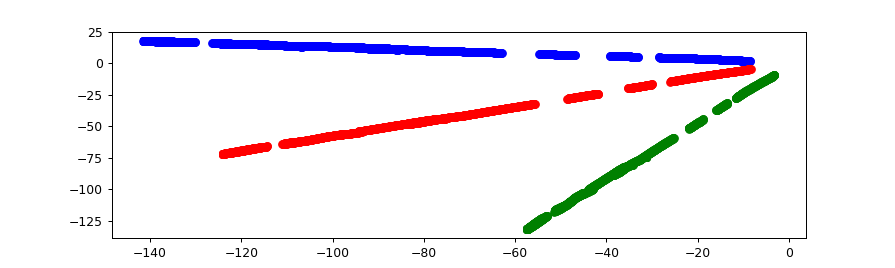

In [3]:
%matplotlib notebook

plt.figure(figsize=(10,3))
plt.scatter(trimble_1[:,1],trimble_1[:,2], color='b')
plt.scatter(trimble_2[:,1],trimble_2[:,2], color='r')
plt.scatter(trimble_3[:,1],trimble_3[:,2], color='g')
#plt.plot(p2s_rarr[:,2], color='g')
plt.show()

In [4]:
print(len(np.array(trimble_1)))
print(len(np.array(trimble_2)))
print(len(np.array(trimble_3)))

1765
1765
1765


In [5]:
ttfu = importlib.reload(ttfu)
rate = 10
speed_limit = 2
index1 = ttfu.find_not_moving_points_GP(np.array(trimble_1), speed_limit, 1/rate) 
index2 = ttfu.find_not_moving_points_GP(np.array(trimble_2), speed_limit, 1/rate) 
index3 = ttfu.find_not_moving_points_GP(np.array(trimble_3), speed_limit, 1/rate)  

In [6]:
ttfu = importlib.reload(ttfu)

#p1s_l = np.array(trimble_1)[:,1:5]
#p2s_l = np.array(trimble_2)[:,1:5]
#p3s_l = np.array(trimble_3)[:,1:5]
p1s_l = np.array(trimble_1)[index1,1:5]
p2s_l = np.array(trimble_2)[index1,1:5]
p3s_l = np.array(trimble_3)[index1,1:5]

threshold_training = 0.75
mask_1 = ttfu.random_splitting_mask(p1s_l, threshold_training)

p1s_t = p1s_l[mask_1]
p2s_t = p2s_l[mask_1]
p3s_t = p3s_l[mask_1]

p1s_p = p1s_l[~mask_1]
p2s_p = p2s_l[~mask_1]
p3s_p = p3s_l[~mask_1]


print(len(np.array(trimble_1).T[0]))
print(len(p1s_l),len(p1s_t),len(p1s_p))

1765
1756 1276 480


In [7]:
cov_1 = np.cov(p1s_t[:,0:3].T)
w1, v1 = np.linalg.eig(cov_1)
print((w1)**0.5)

[3.79473435e+01 2.44240248e-01 1.07548813e-02]


In [8]:
#total_points = np.vstack((p1s_l, p2s_l, p3s_l))
#output = np.mean(total_points, axis=0)
#output[3]=0
#p1s_l = p1s_l-output
#p2s_l = p2s_l-output
#p3s_l = p3s_l-output

In [9]:
ttfu = importlib.reload(ttfu)

#file_name_marker = ['./data/total_station/20220307/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220312/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220314/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220316/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220331-1/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220331-2/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220427/theodolite_reference_prisms.txt']
file_name_marker = ['./data/total_station/20220505_cones/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220505_empty/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220622-1/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220622-2/theodolite_reference_prisms.txt']
#file_name_marker = ['./data/total_station/20220630-1/theodolite_reference_prisms_without_first_two.txt']
#file_name_marker = ['./data/total_station/20220630-2/theodolite_reference_prisms_without_first_two.txt']

marker_1, marker_2, marker_3, T1_basic, T12_basic, T13_basic = ttfu.read_marker_file(file_name_marker[0], 1, 1)


#T12_init = ttfu.point_to_point_minimization(p2s_t.T, p1s_t.T)
#T13_init = ttfu.point_to_point_minimization(p3s_t.T, p1s_t.T)
T12_init = T12_basic
T13_init = T13_basic
T12_init_log = exp_inv_T(T12_init)
T13_init_log = exp_inv_T(T13_init)
x_init = [T12_init_log[2,1],T12_init_log[0,2],T12_init_log[1,0],T12_init_log[0,3],T12_init_log[1,3],T12_init_log[2,3],
      T13_init_log[2,1],T13_init_log[0,2],T13_init_log[1,0],T13_init_log[0,3],T13_init_log[1,3],T13_init_log[2,3]]
#x_init = [T12_init_log[1,0],T12_init_log[0,3],T12_init_log[1,3],T12_init_log[2,3],
#          T13_init_log[1,0],T13_init_log[0,3],T13_init_log[1,3],T13_init_log[2,3]]

<IPython.core.display.Javascript object>


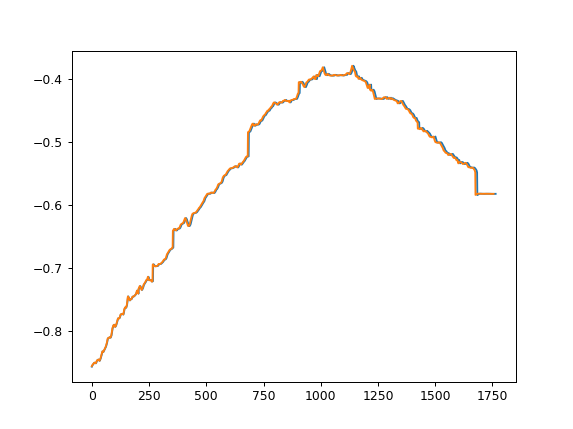

In [10]:
%matplotlib notebook

#plt.figure(figsize=(10,3))
#plt.scatter(p1s_l[:,0],p1s_l[:,2])
#plt.scatter(p2s_l[:,0],p2s_l[:,2])
plt.plot(trimble_2[:,3])
plt.plot(p2s_l[:,2])

plt.show()

In [11]:
import time

# 17 02 2022 / 24 02 2022
#Dist_prism_12 = 0.8882613537922258
#Dist_prism_13 = 0.8262903370535766
#Dist_prism_23 = 1.0377436460567973

# 07 03 2022
#Dist_prism_12 = 0.8832836583456264
#Dist_prism_13 = 0.8247449387008166
#Dist_prism_23 = 1.039409793600046

# 12 03 2022
#Dist_prism_12 = 0.8860734460339026
#Dist_prism_13 = 0.8303896290142598
#Dist_prism_23 = 1.0393117663247973

# 14 03 2022 / 16 03 2022
#Dist_prism_12 = 0.8873171656784946
#Dist_prism_13 = 0.8272212117473343
#Dist_prism_23 = 1.0379270641796363

# 31 03 2022
#Dist_prism_12 = 0.8873171656784946
#Dist_prism_13 = 0.8272212117473343
#Dist_prism_23 = 1.0379270641796363

# 27 04 2022
#Dist_prism_12 = 0.8856608085851714
#Dist_prism_13 = 0.8264452483880412
#Dist_prism_23 = 1.0384219210289538

# 05 05 2022
Dist_prism_12 = 0.3819811991689936
Dist_prism_13 = 0.4426382054042266
Dist_prism_23 = 0.2564685508415531

# 23 05 2022
#Dist_prism_12 = 0.3851913749758221
#Dist_prism_13 = 0.4433899497583272
#Dist_prism_23 = 0.25861327466684897

# 22 06 2022
#Dist_prism_12 = 0.7359204697527427
#Dist_prism_13 = 0.9055056357941131
#Dist_prism_23 = 1.0268390664025775

# 30 06 2022
#Dist_prism_12 = 0.7297583705742492
#Dist_prism_13 = 0.9060320633355149
#Dist_prism_23 = 1.0319114860615324

start_time = time.time()

#res = scipy.optimize.minimize(lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, 
#                            Dist_prism_23), x0=np.zeros((12,1)), tol=1e-8)

#res = scipy.optimize.minimize(lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, 
#                            Dist_prism_23), x0=x_init, method='BFGS', jac=None, 
#                            options={'disp': True, 'gtol': 1e-15, 'eps': 1.4901161193847656e-10, 
#                                     'return_all': True})

#res = scipy.optimize.least_squares(lambda x: cost_fun_ls_4dof(p1s_l, p2s_l, p3s_l, x[:4], x[4:], Dist_prism_12, Dist_prism_13, 
#                                   Dist_prism_23), x0=x_init, method='trf', 
#                                   ftol=1e-15, xtol=1e-15, gtol=1e-15, x_scale=1.0, loss='linear', 
#                                   f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, 
#                                   jac_sparsity=None, max_nfev=30000000, verbose=2, args=(), kwargs={})

res = scipy.optimize.least_squares(lambda x: cost_fun_ls(p1s_t, p2s_t, p3s_t, x[:6], x[6:], Dist_prism_12, Dist_prism_13, 
                                   Dist_prism_23), x0=x_init, method='lm', 
                                   ftol=1e-15, xtol=1e-15, gtol=1e-15, x_scale=1.0, loss='linear', 
                                   f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, 
                                   jac_sparsity=None, max_nfev=30000000, verbose=2, args=(), kwargs={})

stop_time = time.time()
print(stop_time - start_time)
print(res.fun)
xi_12 = res.x[:6]
xi_13 = res.x[6:]
T12 = exp_T(xi_12)
T13 = exp_T(xi_13)
#xi_12 = res.x[:4]
#xi_13 = res.x[4:]
#T12 = exp_T_4dof(xi_12)
#T13 = exp_T_4dof(xi_13)

`xtol` termination condition is satisfied.
Function evaluations 219, initial cost 9.6254e-09, final cost 1.5263e-09, first-order optimality 1.10e-11.
6.348583459854126
[ 3.23442589e-07 -1.26948354e-07  9.83994708e-08 ... -1.13465422e-07
 -1.24600847e-07 -1.35150258e-07]


In [12]:
#print(res)
#print(len(p1s_l))
#print(res.fun/len(p1s_l))

In [13]:
p1s_r = p1s_p
p2s_r = (T12@p2s_p.T).T
p3s_r = (T13@p3s_p.T).T

#p1s_r = np.array(trimble_1)[:,1:5]
#p2s_r = (T12@np.array(trimble_2)[:,1:5].T).T
#p3s_r = (T13@np.array(trimble_3)[:,1:5].T).T

save_tf = False
path_file_type = 'tf-f-2-1-1-1-6-1-L_.csv'
if(save_tf):
    ttfu.save_tf(np.identity(4), T12, T13, "./data/prediction/TS/20220224/"+path_file_type)

A_12 = np.array([exp_inv_T(T12)[2,1],exp_inv_T(T12)[0,2],exp_inv_T(T12)[1,0],exp_inv_T(T12)[0,3],exp_inv_T(T12)[1,3],exp_inv_T(T12)[2,3]])
A_13 =  np.array([exp_inv_T(T13)[2,1],exp_inv_T(T13)[0,2],exp_inv_T(T13)[1,0],exp_inv_T(T13)[0,3],exp_inv_T(T13)[1,3],exp_inv_T(T13)[2,3]])
B_12 =  np.array([exp_inv_T(T12_init)[2,1],exp_inv_T(T12_init)[0,2],exp_inv_T(T12_init)[1,0],exp_inv_T(T12_init)[0,3],exp_inv_T(T12_init)[1,3],exp_inv_T(T12_init)[2,3]])
B_13 =  np.array([exp_inv_T(T13_init)[2,1],exp_inv_T(T13_init)[0,2],exp_inv_T(T13_init)[1,0],exp_inv_T(T13_init)[0,3],exp_inv_T(T13_init)[1,3],exp_inv_T(T13_init)[2,3]])
print(A_12-B_12)
print(A_13-B_13)

[-0.00112221 -0.00018975 -0.00046711 -0.11891141 -0.02652044 -0.09899199]
[-0.00212156 -0.00153496 -0.0005002  -0.10905869 -0.06303652 -0.10256923]


In [14]:
dist_prism_new = []
dist_prism_basic = []
timestamp = np.array(trimble_1)[:,0]
for i in range(0,len(p1s_r)-1):
    dp1 = abs(np.linalg.norm(p1s_r[i,0:3]-p2s_r[i,0:3])-Dist_prism_12)*1000
    dp2 = abs(np.linalg.norm(p1s_r[i,0:3]-p3s_r[i,0:3])-Dist_prism_13)*1000
    dp3 = abs(np.linalg.norm(p3s_r[i,0:3]-p2s_r[i,0:3])-Dist_prism_23)*1000
    dist_prism_new.append(np.array([timestamp[i], dp1, dp2, dp3]))
    
    dp1 = abs(np.linalg.norm(p1s_l[i,0:3]-(T12_basic@p2s_l[i,0:4].T)[0:3])-Dist_prism_12)*1000
    dp2 = abs(np.linalg.norm(p1s_l[i,0:3]-(T13_basic@p3s_l[i,0:4].T)[0:3])-Dist_prism_13)*1000
    dp3 = abs(np.linalg.norm((T13_basic@p3s_l[i,0:4].T)[0:3]-(T12_basic@p2s_l[i,0:4].T)[0:3])-Dist_prism_23)*1000
    dist_prism_basic.append(np.array([timestamp[i], dp1, dp2, dp3]))
dist_prism_new = np.array(dist_prism_new)
dist_prism_basic = np.array(dist_prism_basic)

print("Inter-prism distance error metric")
print("Basic")
print("Mean inter-prism [mm]: ", round(np.mean(dist_prism_basic[:,1]),2), round(np.mean(dist_prism_basic[:,2]),2), round(np.mean(dist_prism_basic[:,3]),2))
print("Std inter-prism [mm]: ", round(np.std(dist_prism_basic[:,1]),2), round(np.std(dist_prism_basic[:,2]),2), round(np.std(dist_prism_basic[:,3]),3))
print("New")
print("Mean inter-prism [mm]: ", round(np.mean(dist_prism_new[:,1]),2), round(np.mean(dist_prism_new[:,2]),2), round(np.mean(dist_prism_new[:,3]),2))
print("Std inter-prism [mm]: ", round(np.std(dist_prism_new[:,1]),2), round(np.std(dist_prism_new[:,2]),2), round(np.std(dist_prism_new[:,3]),3))

Inter-prism distance error metric
Basic
Mean inter-prism [mm]:  5.2 8.59 1.84
Std inter-prism [mm]:  2.28 2.47 1.398
New
Mean inter-prism [mm]:  2.56 2.6 1.78
Std inter-prism [mm]:  2.23 2.45 2.076


Mean inter-prism [mm]:  2.56 2.6 1.78
Std inter-prism [mm]:  2.23 2.45 2.076


<IPython.core.display.Javascript object>


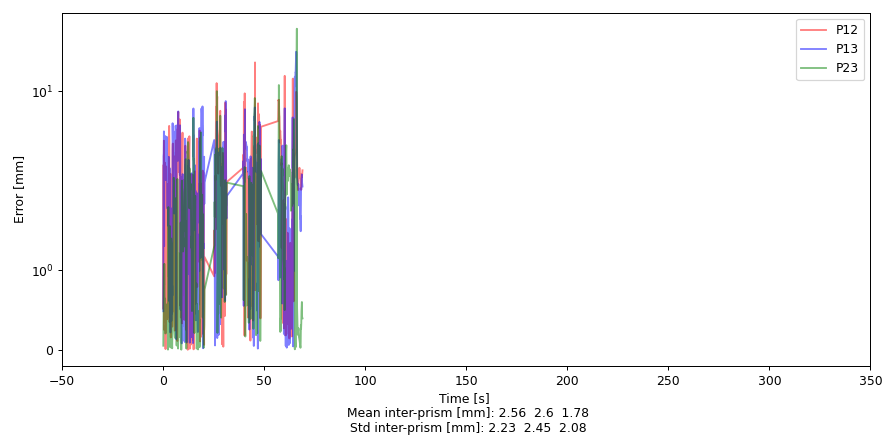

In [15]:
print("Mean inter-prism [mm]: ", round(np.mean(dist_prism_new[:,1]),2), round(np.mean(dist_prism_new[:,2]),2), round(np.mean(dist_prism_new[:,3]),2))
print("Std inter-prism [mm]: ", round(np.std(dist_prism_new[:,1]),2), round(np.std(dist_prism_new[:,2]),2), round(np.std(dist_prism_new[:,3]),3))
plt.figure(figsize=(10,5))
offset_timestamp = min(dist_prism_new[:,0])
plt.subplot(111)
plt.plot(dist_prism_new[:,0]-offset_timestamp, dist_prism_new[:,1], label="P12", color="red", alpha=0.5)
plt.plot(dist_prism_new[:,0]-offset_timestamp, dist_prism_new[:,2], label="P13", color="blue", alpha=0.5)
plt.plot(dist_prism_new[:,0]-offset_timestamp, dist_prism_new[:,3], label="P23", color="green", alpha=0.5)
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylabel("Error [mm]")
limitx = [-50, 350]
ax.set_xlim(limitx)
ax.set_xlabel("Time [s] \n Mean inter-prism [mm]: " + str(round(np.mean(dist_prism_new[:,1]),2)) + "  " + str(round(np.mean(dist_prism_new[:,2]),2)) + "  " + str(round(np.mean(dist_prism_new[:,3]),2))
             + "\n Std inter-prism [mm]: " + str(round(np.std(dist_prism_new[:,1]),2)) + "  " + str(round(np.std(dist_prism_new[:,2]),2)) + "  " + str(round(np.std(dist_prism_new[:,3]),2)))
#plt.savefig("./figs/20220505_cones_dynamic_L-1-6.jpg")
#plt.savefig("./figs/20220505_cones_dynamic.jpg")
plt.tight_layout()
plt.show()  
#plt.savefig("./figs/20220505_empty.jpg")

<IPython.core.display.Javascript object>


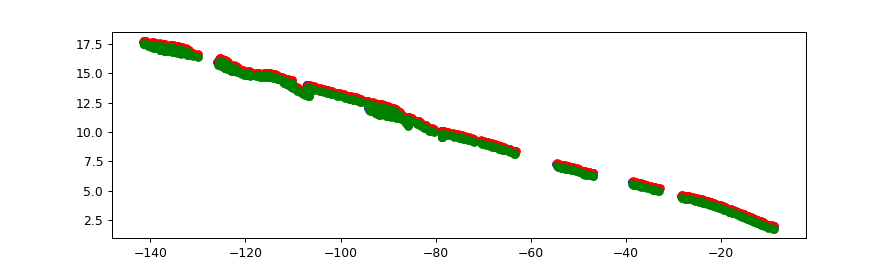

In [16]:
%matplotlib notebook

p2s_rarr = np.array(p2s_r)
p3s_rarr = np.array(p3s_r)

plt.figure(figsize=(10,3))
plt.scatter(p1s_r[:,0],p1s_r[:,1], color='b')
plt.scatter(p2s_rarr[:,0],p2s_rarr[:,1], color='r')
plt.scatter(p3s_rarr[:,0],p3s_rarr[:,1], color='g')
#plt.plot(p2s_rarr[:,2], color='g')
plt.show()

<IPython.core.display.Javascript object>


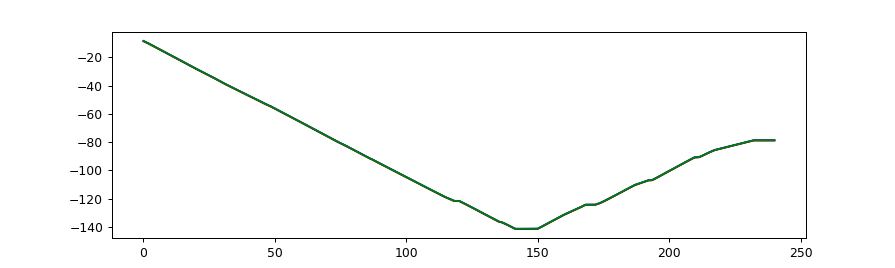

In [17]:
t1s_r = np.array(trimble_1)[:,1:5]
t2s_r = (T12@(np.array(trimble_2)[:,1:5]).T).T
t3s_r = (T13@(np.array(trimble_3)[:,1:5]).T).T

plt.figure(figsize=(10,3))
offset_timestamp = min(np.array(trimble_1)[0,0],np.array(trimble_2)[0,0],np.array(trimble_3)[0,0])
plt.plot(np.array(trimble_1)[:,0]-offset_timestamp,t1s_r[:,0], color='r')
plt.plot(np.array(trimble_2)[:,0]-offset_timestamp,t2s_r[:,0], color='b')
plt.plot(np.array(trimble_3)[:,0]-offset_timestamp,t3s_r[:,0], color='g')
plt.show()

<IPython.core.display.Javascript object>


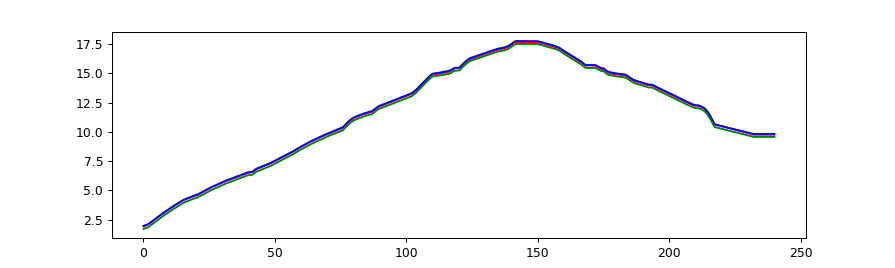

In [18]:
plt.figure(figsize=(10,3))
plt.plot(np.array(trimble_1)[:,0]-offset_timestamp,t1s_r[:,1], color='r')
plt.plot(np.array(trimble_2)[:,0]-offset_timestamp,t2s_r[:,1], color='b')
plt.plot(np.array(trimble_3)[:,0]-offset_timestamp,t3s_r[:,1], color='g')
plt.show()

<IPython.core.display.Javascript object>


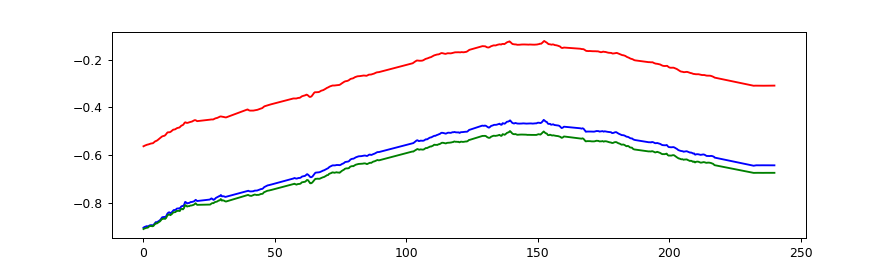

In [19]:
plt.figure(figsize=(10,3))
plt.plot(np.array(trimble_1)[:,0]-offset_timestamp,t1s_r[:,2], color='r')
plt.plot(np.array(trimble_2)[:,0]-offset_timestamp,t2s_r[:,2], color='b')
plt.plot(np.array(trimble_3)[:,0]-offset_timestamp,t3s_r[:,2], color='g')
plt.show()

In [20]:
m1_b = marker_1
m2_b = T12_basic@marker_2
m3_b = T13_basic@marker_3

m1_n = marker_1
m2_n = T12@marker_2
m3_n = T13@marker_3

In [21]:
error_basic = []
error_new = []
for i,j,k in zip(m1_b.T, m2_b.T, m3_b.T):
    dist_12 = np.linalg.norm(i[0:3]-j[0:3])*1000
    dist_13 = np.linalg.norm(i[0:3]-k[0:3])*1000
    dist_23 = np.linalg.norm(k[0:3]-j[0:3])*1000
    error_basic.append(dist_12)
    error_basic.append(dist_13)
    error_basic.append(dist_23)
            
for i,j,k in zip(m1_n.T, m2_n.T, m3_n.T):
    dist_12 = np.linalg.norm(i[0:3]-j[0:3])*1000
    dist_13 = np.linalg.norm(i[0:3]-k[0:3])*1000
    dist_23 = np.linalg.norm(k[0:3]-j[0:3])*1000
    error_new.append(dist_12)
    error_new.append(dist_13)
    error_new.append(dist_23)

print("Control points error metric [mm]")
print("Number control points: ", len(marker_1.T))
print("Basic: ",np.median(error_basic))
print("New: ",np.median(error_new))


Control points error metric [mm]
Number control points:  12
Basic:  1.7384581326418493
New:  156.69036944721478


<IPython.core.display.Javascript object>


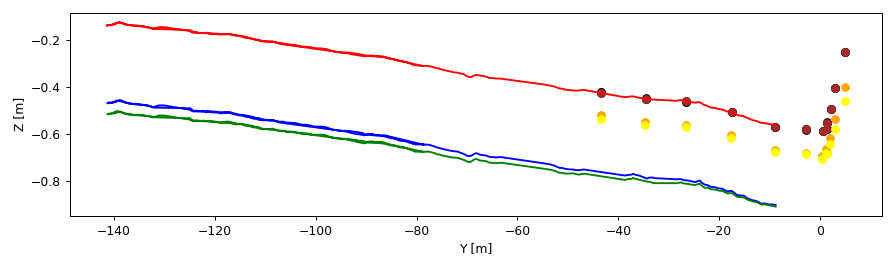

In [22]:
plt.figure(figsize=(10,3))
axis_1 = 0
axis_2 = 2
plt.plot(p1s_r[:,axis_1],p1s_r[:,axis_2], color='r')
plt.plot(p2s_r[:,axis_1],p2s_r[:,axis_2], color='b')
plt.plot(p3s_r[:,axis_1],p3s_r[:,axis_2], color='g')
plt.scatter(m1_b[axis_1,:],m1_b[axis_2,:], color='black')
plt.scatter(m2_b[axis_1,:],m2_b[axis_2,:], color='black')
plt.scatter(m3_b[axis_1,:],m3_b[axis_2,:], color='black')
plt.scatter(m1_n[axis_1,:],m1_n[axis_2,:], color='brown')
plt.scatter(m2_n[axis_1,:],m2_n[axis_2,:], color='orange')
plt.scatter(m3_n[axis_1,:],m3_n[axis_2,:], color='yellow')
plt.xlabel('Y [m]')
plt.ylabel('Z [m]')
plt.tight_layout()
#plt.savefig("./figs/20220505_empty_YZ_plan.jpg")
plt.show()

In [23]:
# Convert point data to csv file
ttfu = importlib.reload(ttfu)

p1_final = np.array(trimble_1)[index1,1:5]
p2_final = (T12@np.array(trimble_2)[index1,1:5].T).T
p3_final = (T13@np.array(trimble_3)[index1,1:5].T).T

folder = "TS/20220505_cones/"

# Trajectory total station (time, point data) x3
ttfu.Convert_datap_to_csv(np.array(trimble_1)[:,0], p1_final, "./data/prediction/"+folder+"results/nr_trimble_1.csv")
ttfu.Convert_datap_to_csv(np.array(trimble_2)[:,0], p2_final, "./data/prediction/"+folder+"results/nr_trimble_2.csv")
ttfu.Convert_datap_to_csv(np.array(trimble_3)[:,0], p3_final, "./data/prediction/"+folder+"results/nr_trimble_3.csv")

Conversion done !
Conversion done !
Conversion done !


In [24]:
ttfu = importlib.reload(ttfu)
save_tf = True
name_file = './data/calibration/tf_automated_resection/20220505_cones_tf.csv'
if(save_tf):
    ttfu.save_tf(np.identity(4), T12, T13, name_file)

Conversion done !
